# Project 1: End-to-End Pipeline to Classify News Articles

## Question 1

### 1.1 Overview How many rows (samples) and columns (features) are present in the dataset?

In [36]:
import pandas as pd

df = pd.read_csv('Project1-ClassificationDataset.csv')

num_rows, num_cols = df.shape

print(f"Number of rows (samples): {num_rows}")
print(f"Number of cols (features): {num_cols}")

Number of rows (samples): 3476
Number of cols (features): 8


### 1.2 Histograms

#### (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis

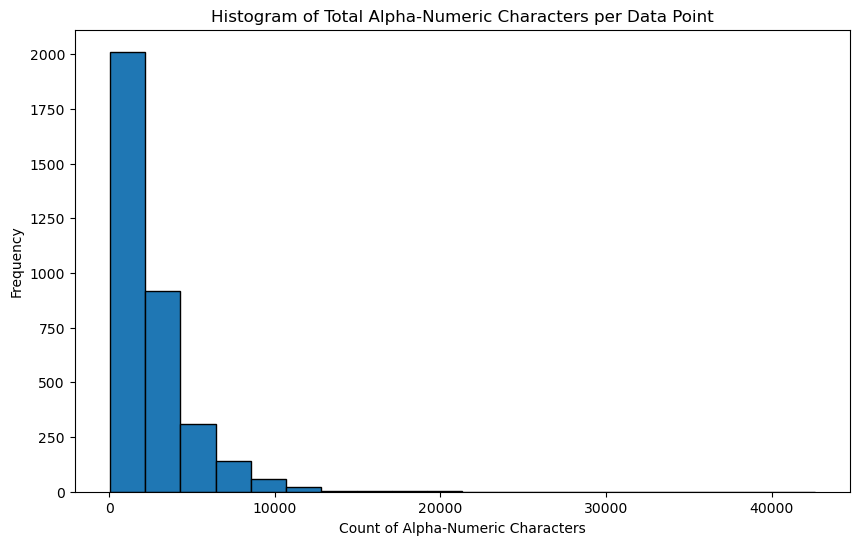

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file into a DataFrame
file_path = 'Project1-ClassificationDataset.csv'
df = pd.read_csv(file_path)

# (a) Histogram for the total number of alpha-numeric characters per data point
df['Total_AlphaNumeric_Count'] = df['full_text'].apply(lambda x: sum(c.isalnum() for c in str(x)))
plt.figure(figsize=(10, 6))
plt.hist(df['Total_AlphaNumeric_Count'], bins=20, edgecolor='black')
plt.title('Histogram of Total Alpha-Numeric Characters per Data Point')
plt.xlabel('Count of Alpha-Numeric Characters')
plt.ylabel('Frequency')
plt.show()

#### (b) The column leaf label – class on the x-axis

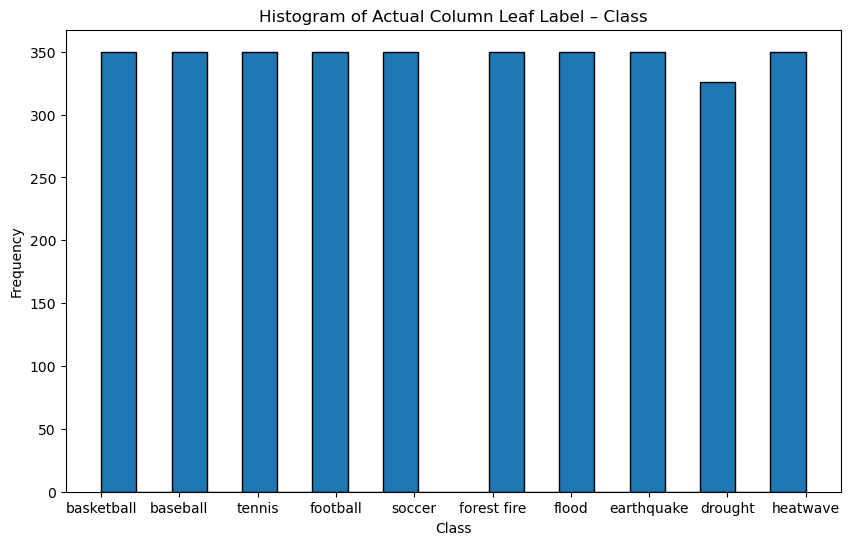

In [38]:
# (b) Histogram for the actual column leaf label – class
leaf_label_column = 'leaf_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[leaf_label_column], bins=20, edgecolor='black')
plt.title('Histogram of Actual Column Leaf Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


#### (c) The column root label – class on the x-axis.

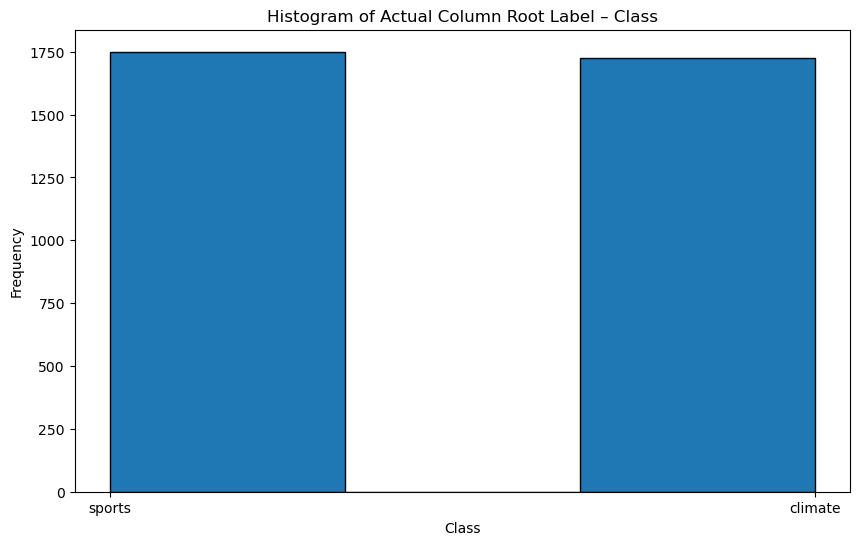

In [39]:
# (c) Histogram for the actual column root label – class
root_label_column = 'root_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[root_label_column], bins=3, edgecolor='black')
plt.title('Histogram of Actual Column Root Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### 1.3 Interpret Plots: Provide qualitative interpretations of the histograms.

** incomplete **

(a) Histogram of Alpha Numeric Characters per Data Point
- Histogram reveals the distribution of the total number of alpha-numeric characters in the 'full_text' feature for each data point

(b) Histogram of Leaf Label Class
- b

(c) Histogram of Root Label Class
- c

## Question 2

In [40]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

### Report the number of training and testing samples.

In [41]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

num_training_samples = len(train)
num_testing_samples = len(test)

print(f"Number of training samples: {num_training_samples}")
print(f"Number of testing samples: {num_testing_samples}")

Number of training samples: 2780
Number of testing samples: 696


## Question 3


### 3.1 Cleaning each data sample. This function helps remove many but not all HTML artefacts from the crawler’s output. 

In [42]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

Call the clean(text) function to clean the crawler's output and remove most HTML artefacts 

In [43]:
train['full_text'] = train['full_text'].map(clean)
test['full_text'] = test['full_text'].map(clean)

### 3.2 Create the CountVectorizer with "english" stopword

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=3, stop_words="english")

### 3.3, 3.4, 3.5 Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag and Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.) using min_df=3

In [45]:
# Lemmatization
import nltk
from nltk import pos_tag

# nltk.download()
wnl = nltk.wordnet.WordNetLemmatizer()

# Penn Trebank to wordnet 
# In the wordnet (ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v', POS_LIST = [NOUN, VERB, ADJ, ADV])
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

# Lemmatize entire data (data made up of sentences. Lemmatize ever word in every sentence and return the lemmatized data)
def lemmatize(data):
    lemmatized_data = [] 
    for text in data:
        # print("text": text)
        # Return a tokenized copy of text 
        tokens = nltk.word_tokenize(text)
        # print(tokens)
        
        # tags given list of tokens 
        tagged = pos_tag(tokens)
        # print(tagged)

        # lemmatize text excluding numbers 
        lemmatized_words = []
        for word, tag in tagged:
            # print("word: " word)
            if not re.match(r'^\d+(\.\d+)?$', word): # double check this
                lemmatized_word = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
                lemmatized_words.append(lemmatized_word)
            
        lemmatized_sentence = ' '.join(lemmatized_words)
        
        # Add whole sentence back to the lemmatize_data array 
        lemmatized_data.append(lemmatized_sentence)

    return lemmatized_data

In [46]:
# Lemmatize train and test datasets 
train_lemmatized = lemmatize(train['full_text'])
test_lemmatized = lemmatize(test['full_text'])

In [61]:
# Vectorize the lemmatized train and test datasets 
X_train_counts = count_vect.fit_transform(train_lemmatized)
X_test_counts = count_vect.transform(test_lemmatized)

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer
# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("TD-TFIDF-processed Train Matrix Shape: ", X_train_tfidf.shape)
print("TD-TFIDF-processed Test Matrix Shape: ", X_test_tfidf.shape)

TD-TFIDF-processed Train Matrix Shape:  (2780, 13754)
TD-TFIDF-processed Test Matrix Shape:  (696, 13754)


### 3.6 Answer Questions 

#### (a) What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?
**Lemmatization:** 
It is a technique that involves reducing words to their root form, which is called lemma. 

Pros
1) The base/root words are actual words with meanings. So after lemmatization we do not lose the meaning of a word. 
2) In lemmatization, since we retain the meaning of the words, the accuracy is better than stemming.

Cons
1) It is slower than stemming. 
2) To implement lemmatization we need to have some linguistic understanding. 

**Stemming:** 
Stemming removes suffixes and prefixes from words, so that we can get a common representation called the stem of a word. 

Pros
1) Stemming is less computationally expensive and runs faster. Stemming is easy to implement as it does not take into account the meanings of words.
2)  Stemming helps in reducing the dictionary size. 

Cons
1) The words we obtain after stemming may not be valid words with some meaning. 
2) The acccuracy might be lesser as compared to lemmatization. 

**Dictionary size:**
Stemming gives a smaller dictionary size as it does not consider the meaning of a word, it just reduces the word by removing prefixes or suffixes. Whereas, lemmatization takes into account the meaning and results in a larger dictionary size. 

#### (b) min df means minimum document frequency. How does varying min df change the TF-IDF matrix?
The min_df parameter is used to remove the terms that are very infrequent. If min_df = 3 that means ignore the terms that appear in less than 3 documents. 


#### (c) Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.
- The stopwords are removed after applying the lemmatizer. The punctuations are removed before lemmatizing, and the removing the numbers is also removed before lemmatizing.

#### (d) Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×(10^3). This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.
- The shape of the TD-IDF-processed train matrix is (2780, 13754). The shape of the TD-IDF-processed test matrix is (696, 13754). 

## Question 4

In [72]:
# LSI
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components=50, random_state=0)
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)

In [74]:
# NMF
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

### 4.1.1 Plot the explained variance ratio.

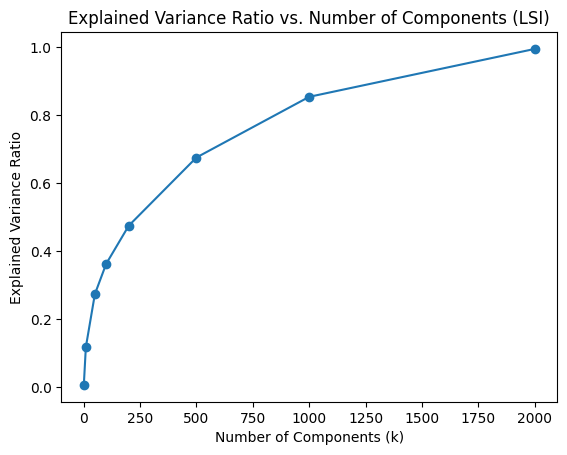

In [65]:
# NOT VALIDATED
import matplotlib.pyplot as plt

# Define values of k
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]

# Plot explained variance ratio for different values of k
explained_variances = []

for k in k_values:
    lsi = TruncatedSVD(n_components=k, random_state=0)
    explained_variances.append(lsi.explained_variance_ratio_.sum())

plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components (LSI)')
plt.show()

### 4.1.2 What does the explained variance ratio plot look like? 

incomplete

### 4.1.3 What does the plot’s concavity suggest?
incomplete 

### 4.2.1 Calculate the reconstruction residual MSE error. 

In [79]:
# LSI Reconstructed Residual MSE Error 
USigmaVt = lsi.inverse_transform(X_train_lsi)
residual_MSE_lsi = np.sum(np.array(X_train_tfidf - USigmaVt)**2)

# NMF Reconstructed Residual MSE Error 
WH = np.dot(X_train_NMF, nmf.components_)
residual_MSE_nmf = np.sum(np.array(X_train_tfidf - WH)**2)

### 4.2.2 Which one is larger, NMF or LSI and why? 

In [76]:
if residual_MSE_lsi > residual_MSE_nmf: 
    print("LSI has a larger residual MSE error than NMF.")
elif residual_MSE_lsi < residual_MSE_nmf: 
    print("NMF has a larger residual MSE error than LSI.")
else: 
    print("NMF has the same residual MSE error as LSI.")

NMF has a larger residual MSE error than LSI.


incomplete (explain why)

## Question 5

### 5.1.1 Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).

### 5.1.2 Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

### 5.1.3 What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

### 5.1.4 Does the ROC curve reflect the performance of the soft-margin SVM? Why?

### 5.2.1 Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6, k ∈ Z}. 

### 5.2.2 Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.